# U-Net


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
import progressbar
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib
from torchvision import transforms
from glob import glob
from skimage import io
from sklearn.feature_extraction.image import extract_patches_2d,reconstruct_from_patches_2d
import pickle
from torch.utils.data import Dataset
%matplotlib inline
import cv2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [3]:
progress = progressbar.ProgressBar(widgets=[progressbar.Bar('*', '[', ']'), progressbar.Percentage(), ' '])

In [4]:
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        # define forward operation using the layers we have defined
        x = self.relu(self.bn(self.conv(x)))
        return x

# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self):
        super(down, self).__init__()
        self.down = nn.MaxPool2d((2, 2)) # use nn.MaxPool2d( )
        
    def forward(self, x):
        x = self.down(x)
        
        return x


# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self):
        super(up, self).__init__()       
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')  # use nn.Upsample() with mode bilinear

    def forward(self, x1, x2): # Takes in smaller x1 and larger x2
        # First we upsample x1 to be same size as x2
        x1 = self.up(x1)
        
        # This part is tricky so we've completed this
        # Notice that x2 and x1 may not have the same spatial size. 
        # This is because when you downsample old_x2(say 25 by 25), you will get x1(12 by 12)   
        # Then you perform upsample to x1, you will get new_x1(24 by 24)
        # You should pad a new row and column so that new_x1 and x2 have the same size.
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 and x1 along channel dimension: torch.cat()
        # Note pytorch tensor shape correspond to: (batchsize, channel, x_dim, y_dim)
        x = torch.cat((x1,x2), dim=1)
        
        return x


# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=1,stride=1,padding=0)

    def forward(self, x):
        x = self.conv(x)
        
        return x


In [5]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels_in, n_channels_out):
        super(UNet, self).__init__()
        ## Define the necessary layers using the classes defined above
        self.conv1=single_conv(n_channels_in,16)
        self.down=down()
        self.up=up()
        self.conv2=single_conv(16,32)
        self.conv3=single_conv(32,32)
        self.conv4=single_conv(64,16)
        self.conv5=single_conv(32,16)
        self.outconv=outconv(16,n_channels_out)


    def forward(self, x):
        # Define forward pass
        x0=self.conv1(x)
        x1=self.down(x0)
        x1=self.conv2(x1)
        x2=self.down(x1)
        x2=self.conv3(x2)
        x3=self.up(x2,x1)
        x3=self.conv4(x3)
        x=self.up(x3,x0)
        x=self.conv5(x)
        x=self.outconv(x)
        
        return x
    

In [6]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [7]:
train_img_masks_save_path = 'Pickles/train_img_masks.pickle'
if os.path.exists(train_img_masks_save_path):
    with open(train_img_masks_save_path,'rb') as f:
        train_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Training Set Pickle not found!')

val_img_masks_save_path = 'Pickles/val_img_masks.pickle'
if os.path.exists(val_img_masks_save_path):
    with open(val_img_masks_save_path,'rb') as f:
        val_img_masks = pickle.load(f)
    f.close()
else:
    print('Error! Validation Set Pickle not found!')

In [8]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, image_masks, transforms=None): 

        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):

        image = np.array(self.image_masks[index][0]) # Channel,H, W
        mask = self.image_masks[index][1]
        
        sample = {'img': image, 'label': mask}
        
        if transforms:
            sample = self.transforms(sample)
            
        return sample

train_dataset = CustomDataset(train_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(val_img_masks, transforms=transforms.Compose([Flip(),ToTensor()]))

In [9]:
# Create Model object from the class defined above. Input channels = 4, output channels = 5
net = UNet(4,5).to(device,dtype=torch.float32)
net.to(device) 
# if using GPU
# If continuing from previously saved model, use 
# net.load_state_dict(torch.load('PATH TO SAVED MODEL FILE'))
print(net)

# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

UNet(
  (conv1): single_conv(
    (conv): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (down): down(
    (down): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (up): up(
    (up): Upsample(scale_factor=2.0, mode=bilinear)
  )
  (conv2): single_conv(
    (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv3): single_conv(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv4): single_conv(
    (conv): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True,

In [10]:
# Specify number of epochs, image scale factor, batch size and learning rate
epochs =  100        # e.g. 10, or more until CE converge
batch_size = 40    # e.g. 16
lr =   0.001          # e.g. 0.01
N_train = len(train_img_masks)
if not os.path.exists('Model_1'):
    os.mkdir('Model_1')
model_save_path = 'Model_1/'  # directory to same the model after each epoch. 

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9,weight_decay=0.0005)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

# The loss function we use is Cross Entropy
criterion = nn.CrossEntropyLoss()

# Start training  #This part takes very long time to run if using CPU
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    
    epoch_loss = 0
    count = 0
    progress.currval = 0
    progress.max_value=len(train_loader)-1
    progress.start()
    for i, b in enumerate(train_loader):
        
        imgs = b['img'].to(device,dtype=torch.float32)
        true_masks = b['label'].to(device,dtype=torch.long)        
        masks_pred = net(imgs)
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = criterion(masks_pred,true_masks.long())
        epoch_loss += loss
        if count % 20 == 0:  #Print status every 20 batch
            print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item())) 
        count = count + 1
        progress.update(i)
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    net.eval()
    val_cross=0.0
    val_tot=1
    with torch.no_grad():
        progress.currval = 0
        progress.max_value=len(val_loader)-1
        progress.start()
        for i, b in enumerate(val_loader):
            vimgs = b['img'].to(device,dtype=torch.float32)
            vtrue_masks = b['label'].to(device,dtype=torch.long)
            vmasks_pred = net(vimgs)
            vloss=criterion(vmasks_pred,vtrue_masks.long())
            val_cross += vloss
            val_tot=i+1
            progress.update(i)
    print('Validation Cross-Entropy Coeff: {}'.format(val_cross/i))
    
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Brain_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))

    

[                                                                        ]N/A% 

Starting epoch 1/100.


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
[****                                                                    ]  6% 

0.0000 --- loss: 1.728394


[**********************                                                  ] 31% 

0.2000 --- loss: 1.430888


[***********************************                                     ] 49% 

0.4000 --- loss: 1.364657


[***************************************************                     ] 71% 

0.6000 --- loss: 1.186183


[***************************************************************         ] 87% 

0.8000 --- loss: 1.041553


[                                                                        ]N/A% 

Epoch finished ! Loss: 1.2915095090866089
Validation Cross-Entropy Coeff: 1.0303250551223755
Checkpoint 1 saved !
Starting epoch 2/100.
0.0000 --- loss: 0.995399

[*********************                                                   ] 29% 

0.2000 --- loss: 0.967076


[*************************************                                   ] 51% 

0.4000 --- loss: 0.883065


[***************************************************                     ] 71% 

0.6000 --- loss: 0.889826


[******************************************************************      ] 91% 

0.8000 --- loss: 0.796675


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.9415095448493958
Validation Cross-Entropy Coeff: 0.8560175895690918
Checkpoint 2 saved !
Starting epoch 3/100.
0.0000 --- loss: 0.890037


[**********************                                                  ] 31% 

0.2000 --- loss: 0.742268


[**********************************                                      ] 47% 

0.4000 --- loss: 0.863660


[***************************************************                     ] 71% 

0.6000 --- loss: 0.850523


[****************************************************************        ] 88% 

0.8000 --- loss: 0.752353


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.8243234157562256
Validation Cross-Entropy Coeff: 0.7686100006103516
Checkpoint 3 saved !
Starting epoch 4/100.
0.0000 --- loss: 0.731203


[**********************                                                  ] 31% 

0.2000 --- loss: 0.652371


[*************************************                                   ] 51% 

0.4000 --- loss: 0.741190


[***************************************************                     ] 71% 

0.6000 --- loss: 0.733127


[******************************************************************      ] 91% 

0.8000 --- loss: 0.634450


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.7627637386322021
Validation Cross-Entropy Coeff: 0.7162224650382996
Checkpoint 4 saved !
Starting epoch 5/100.
0.0000 --- loss: 0.818682


[***********************                                                 ] 32% 

0.2000 --- loss: 0.726576


[*************************************                                   ] 51% 

0.4000 --- loss: 0.724172


[***************************************************                     ] 71% 

0.6000 --- loss: 0.662257


[****************************************************************        ] 89% 

0.8000 --- loss: 0.637390


Epoch finished ! Loss: 0.7285264134407043
Validation Cross-Entropy Coeff: 0.7082765102386475
Checkpoint 5 saved !
Starting epoch 6/100.
0.0000 --- loss: 0.804082


[**********************                                                  ] 31% 

0.2000 --- loss: 0.650508


[***********************************                                     ] 49% 

0.4000 --- loss: 0.668278


[***************************************************                     ] 71% 

0.6000 --- loss: 0.812987


[**************************************************************          ] 86% 

0.8000 --- loss: 0.776282


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.7030444741249084
Validation Cross-Entropy Coeff: 0.6678983569145203
Checkpoint 6 saved !
Starting epoch 7/100.
0.0000 --- loss: 0.763904


[**********************                                                  ] 31% 

0.2000 --- loss: 0.665481


[*************************************                                   ] 51% 

0.4000 --- loss: 0.621260


[**************************************************                      ] 69% 

0.6000 --- loss: 0.792261


[******************************************************************      ] 91% 

0.8000 --- loss: 0.713899


[*********************************************************************   ] 95% 

Epoch finished ! Loss: 0.6867576241493225
Validation Cross-Entropy Coeff: 0.6917678713798523
Checkpoint 7 saved !


Starting epoch 8/100.
0.0000 --- loss: 0.717816


[**********************                                                  ] 31% 

0.2000 --- loss: 0.682309


[**********************************                                      ] 48% 

0.4000 --- loss: 0.609523


[***************************************************                     ] 71% 

0.6000 --- loss: 0.611661


[****************************************************************        ] 89% 

0.8000 --- loss: 0.592472


[************************************************************************]100% 

Epoch finished ! Loss: 0.6665159463882446
Validation Cross-Entropy Coeff: 0.6392553448677063
Checkpoint 8 saved !


Starting epoch 9/100.
0.0000 --- loss: 0.688408


[**********************                                                  ] 31% 

0.2000 --- loss: 0.654886


[**********************************                                      ] 47% 

0.4000 --- loss: 0.683284


[************************************************                        ] 67% 

0.6000 --- loss: 0.631051


[****************************************************************        ] 89% 

0.8000 --- loss: 0.626199


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6530904769897461
Validation Cross-Entropy Coeff: 0.6246805191040039
Checkpoint 9 saved !
Starting epoch 10/100.
0.0000 --- loss: 0.592459


[**********************                                                  ] 31% 

0.2000 --- loss: 0.727414


[***********************************                                     ] 49% 

0.4000 --- loss: 0.752630


[**************************************************                      ] 69% 

0.6000 --- loss: 0.628956


[****************************************************************        ] 89% 

0.8000 --- loss: 0.601471


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.643239438533783
Validation Cross-Entropy Coeff: 0.6296776533126831
Checkpoint 10 saved !
Starting epoch 11/100.
0.0000 --- loss: 0.525182


[**********************                                                  ] 31% 

0.2000 --- loss: 0.609669


0.4000 --- loss: 0.657702


[***************************************************                     ] 71% 

0.6000 --- loss: 0.609535


[******************************************************************      ] 91% 

0.8000 --- loss: 0.736656


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6367912888526917
Validation Cross-Entropy Coeff: 0.6307874321937561
Checkpoint 11 saved !
Starting epoch 12/100.


0.0000 --- loss: 0.629722


[**********************                                                  ] 31% 

0.2000 --- loss: 0.599579


[***********************************                                     ] 49% 

0.4000 --- loss: 0.659522


[**************************************************                      ] 69% 

0.6000 --- loss: 0.624396


[****************************************************************        ] 88% 

0.8000 --- loss: 0.574593


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6306292414665222
Validation Cross-Entropy Coeff: 0.6112082004547119
Checkpoint 12 saved !
Starting epoch 13/100.
0.0000 --- loss: 0.590319


[**********************                                                  ] 31% 

0.2000 --- loss: 0.623967


[**********************************                                      ] 48% 

0.4000 --- loss: 0.645133


[***************************************************                     ] 71% 

0.6000 --- loss: 0.543216


[****************************************************************        ] 88% 

0.8000 --- loss: 0.634153


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6233513355255127
Validation Cross-Entropy Coeff: 0.5999628901481628
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.564276


[**********************                                                  ] 31% 

0.2000 --- loss: 0.550359


[**********************************                                      ] 48% 

0.4000 --- loss: 0.572337


[*************************************************                       ] 68% 

0.6000 --- loss: 0.667381


[******************************************************************      ] 91% 

0.8000 --- loss: 0.583622


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6145187020301819
Validation Cross-Entropy Coeff: 0.5861682295799255
Checkpoint 14 saved !
Starting epoch 15/100.
0.0000 --- loss: 0.649392


[*******************                                                     ] 27% 

0.2000 --- loss: 0.631151


[*************************************                                   ] 51% 

0.4000 --- loss: 0.589900


[***************************************************                     ] 71% 

0.6000 --- loss: 0.618677


[******************************************************************      ] 91% 

0.8000 --- loss: 0.735874


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6099556684494019
Validation Cross-Entropy Coeff: 0.5913063883781433
Checkpoint 15 saved !
Starting epoch 16/100.
0.0000 --- loss: 0.606181


[**********************                                                  ] 31% 

0.2000 --- loss: 0.567930


[*************************************                                   ] 51% 

0.4000 --- loss: 0.600638


[***************************************************                     ] 71% 

0.6000 --- loss: 0.712946


[******************************************************************      ] 91% 

0.8000 --- loss: 0.556670


[**                                                                      ]  3% 

Epoch finished ! Loss: 0.6082887649536133
Validation Cross-Entropy Coeff: 0.5913406014442444
Checkpoint 16 saved !
Starting epoch 17/100.
0.0000 --- loss: 0.619533


[**********************                                                  ] 31% 

0.2000 --- loss: 0.588420


[**********************************                                      ] 47% 

0.4000 --- loss: 0.599202


[***************************************************                     ] 71% 

0.6000 --- loss: 0.599310


[****************************************************************        ] 89% 

0.8000 --- loss: 0.560994


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.603615939617157
Validation Cross-Entropy Coeff: 0.6402223110198975
Checkpoint 17 saved !
Starting epoch 18/100.
0.0000 --- loss: 0.589034


[*********************                                                   ] 29% 

0.2000 --- loss: 0.555546


[*************************************                                   ] 51% 

0.4000 --- loss: 0.522753


[***************************************************                     ] 71% 

0.6000 --- loss: 0.486892


[******************************************************************      ] 91% 

0.8000 --- loss: 0.560250


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6010942459106445
Validation Cross-Entropy Coeff: 0.5904446840286255
Checkpoint 18 saved !
Starting epoch 19/100.
0.0000 --- loss: 0.661148


[**********************                                                  ] 31% 

0.2000 --- loss: 0.568996


[*************************************                                   ] 51% 

0.4000 --- loss: 0.593411


[**************************************************                      ] 69% 

0.6000 --- loss: 0.552846


[***************************************************************         ] 87% 

0.8000 --- loss: 0.591757


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.6000770926475525
Validation Cross-Entropy Coeff: 0.5941610336303711
Checkpoint 19 saved !
Starting epoch 20/100.
0.0000 --- loss: 0.565589

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.626616


[*************************************                                   ] 51% 

0.4000 --- loss: 0.671985


[***************************************************                     ] 71% 

0.6000 --- loss: 0.633266


[******************************************************************      ] 91% 

0.8000 --- loss: 0.621704


[*********************************************************************   ] 95% 

Epoch finished ! Loss: 0.5945898294448853
Validation Cross-Entropy Coeff: 0.5747072696685791
Checkpoint 20 saved !

[********                                                                ] 11% 


Starting epoch 21/100.
0.0000 --- loss: 0.655618


[**********************                                                  ] 31% 

0.2000 --- loss: 0.539820


[*************************************                                   ] 51% 

0.4000 --- loss: 0.553291


[****************************************************                    ] 72% 

0.6000 --- loss: 0.535474


[******************************************************************      ] 91% 

0.8000 --- loss: 0.634687


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5890008807182312
Validation Cross-Entropy Coeff: 0.5749557018280029
Checkpoint 21 saved !
Starting epoch 22/100.
0.0000 --- loss: 0.568510


[***********************                                                 ] 32% 

0.2000 --- loss: 0.490052


0.4000 --- loss: 0.555017


[*************************************************                       ] 68% 

0.6000 --- loss: 0.800180


[****************************************************************        ] 88% 

0.8000 --- loss: 0.721058


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5905012488365173
Validation Cross-Entropy Coeff: 0.5857068300247192
Checkpoint 22 saved !
Starting epoch 23/100.


[********                                                                ] 11% 

0.0000 --- loss: 0.500871


[**********************                                                  ] 31% 

0.2000 --- loss: 0.603235


[**********************************                                      ] 48% 

0.4000 --- loss: 0.573753


[****************************************************                    ] 72% 

0.6000 --- loss: 0.520023


[******************************************************************      ] 91% 

0.8000 --- loss: 0.564353


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5885554552078247
Validation Cross-Entropy Coeff: 0.565190851688385
Checkpoint 23 saved !
Starting epoch 24/100.
0.0000 --- loss: 0.605674

[********                                                                ] 11% 

[*******************                                                     ] 27% 

0.2000 --- loss: 0.545446


[*************************************                                   ] 51% 

0.4000 --- loss: 0.596211


[**************************************************                      ] 69% 

0.6000 --- loss: 0.541188


[****************************************************************        ] 89% 

0.8000 --- loss: 0.522000


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5875946283340454
Validation Cross-Entropy Coeff: 0.5979152917861938
Checkpoint 24 saved !
Starting epoch 25/100.
0.0000 --- loss: 0.484472


[*********************                                                   ] 29% 

0.2000 --- loss: 0.515409


[**********************************                                      ] 48% 

0.4000 --- loss: 0.494331


[***************************************************                     ] 71% 

0.6000 --- loss: 0.608457


[******************************************************************      ] 91% 

0.8000 --- loss: 0.502108


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5798527002334595
Validation Cross-Entropy Coeff: 0.59527587890625
Checkpoint 25 saved !
Starting epoch 26/100.
0.0000 --- loss: 0.661067

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.646471


[*************************************                                   ] 51% 

0.4000 --- loss: 0.607179


[************************************************                        ] 66% 

0.6000 --- loss: 0.535651


[****************************************************************        ] 89% 

0.8000 --- loss: 0.619707


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.578827440738678
Validation Cross-Entropy Coeff: 0.5534632205963135
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.538607


[**********************                                                  ] 31% 

0.2000 --- loss: 0.539184


[**********************************                                      ] 48% 

0.4000 --- loss: 0.586564


[**************************************************                      ] 69% 

0.6000 --- loss: 0.582081


[******************************************************************      ] 91% 

0.8000 --- loss: 0.590613


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5771093368530273
Validation Cross-Entropy Coeff: 0.5583786964416504
Checkpoint 27 saved !
Starting epoch 28/100.
0.0000 --- loss: 0.518598

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.639568


[***********************************                                     ] 49% 

0.4000 --- loss: 0.733550


[************************************************                        ] 67% 

0.6000 --- loss: 0.544676


[****************************************************************        ] 89% 

0.8000 --- loss: 0.564666


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5713358521461487
Validation Cross-Entropy Coeff: 0.5621383190155029
Checkpoint 28 saved !
Starting epoch 29/100.
0.0000 --- loss: 0.669746

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.562848


[*************************************                                   ] 51% 

0.4000 --- loss: 0.517489


[***************************************************                     ] 71% 

0.6000 --- loss: 0.607225


[******************************************************************      ] 91% 

0.8000 --- loss: 0.598151


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5713163018226624
Validation Cross-Entropy Coeff: 0.5612295866012573
Checkpoint 29 saved !
Starting epoch 30/100.
0.0000 --- loss: 0.534449


[**********************                                                  ] 31% 

0.2000 --- loss: 0.498969


[*************************************                                   ] 51% 

0.4000 --- loss: 0.676781


[***************************************************                     ] 71% 

0.6000 --- loss: 0.620697


[****************************************************************        ] 89% 

0.8000 --- loss: 0.528127


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5715329051017761
Validation Cross-Entropy Coeff: 0.5578212738037109
Checkpoint 30 saved !
Starting epoch 31/100.
0.0000 --- loss: 0.569918


[********************                                                    ] 28% 

0.2000 --- loss: 0.560582


[*************************************                                   ] 51% 

0.4000 --- loss: 0.575088


[**************************************************                      ] 69% 

0.6000 --- loss: 0.706614


[****************************************************************        ] 89% 

0.8000 --- loss: 0.500931


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5693032741546631
Validation Cross-Entropy Coeff: 0.562907338142395
Checkpoint 31 saved !
Starting epoch 32/100.
0.0000 --- loss: 0.603253


[**********************                                                  ] 31% 

0.2000 --- loss: 0.560953


[*************************************                                   ] 51% 

0.4000 --- loss: 0.538087


[***************************************************                     ] 71% 

0.6000 --- loss: 0.518567


[******************************************************************      ] 92% 

0.8000 --- loss: 0.557577


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.565923810005188
Validation Cross-Entropy Coeff: 0.547730028629303
Checkpoint 32 saved !
Starting epoch 33/100.
0.0000 --- loss: 0.575355

[********                                                                ] 11% 

[*********************                                                   ] 29% 

0.2000 --- loss: 0.507210


[*************************************                                   ] 51% 

0.4000 --- loss: 0.600457


[***************************************************                     ] 71% 

0.6000 --- loss: 0.623262


[******************************************************************      ] 91% 

0.8000 --- loss: 0.544503


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5664580464363098
Validation Cross-Entropy Coeff: 0.5796325206756592
Checkpoint 33 saved !
Starting epoch 34/100.
0.0000 --- loss: 0.580723


[**********************                                                  ] 31% 

0.2000 --- loss: 0.547209


[***********************************                                     ] 49% 

0.4000 --- loss: 0.503890


[************************************************                        ] 66% 

0.6000 --- loss: 0.576796


[******************************************************************      ] 91% 

0.8000 --- loss: 0.590025


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5659076571464539
Validation Cross-Entropy Coeff: 0.5411650538444519
Checkpoint 34 saved !
Starting epoch 35/100.
0.0000 --- loss: 0.577537


[**********************                                                  ] 31% 

0.2000 --- loss: 0.563571


[**********************************                                      ] 48% 

0.4000 --- loss: 0.570908


0.6000 --- loss: 0.470974


[***************************************************************         ] 87% 

0.8000 --- loss: 0.531863


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5621070265769958
Validation Cross-Entropy Coeff: 0.5473647713661194
Checkpoint 35 saved !
Starting epoch 36/100.
0.0000 --- loss: 0.506901


[*******************                                                     ] 27% 

0.2000 --- loss: 0.529797


[*************************************                                   ] 51% 

0.4000 --- loss: 0.593528


[**************************************************                      ] 69% 

0.6000 --- loss: 0.485218


[****************************************************************        ] 88% 

0.8000 --- loss: 0.509956


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5652335286140442
Validation Cross-Entropy Coeff: 0.5502289533615112
Checkpoint 36 saved !
Starting epoch 37/100.
0.0000 --- loss: 0.469686


[**********************                                                  ] 31% 

0.2000 --- loss: 0.633821


[*************************************                                   ] 51% 

0.4000 --- loss: 0.573781


[***************************************************                     ] 71% 

0.6000 --- loss: 0.522332


[******************************************************************      ] 91% 

0.8000 --- loss: 0.645613


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5591479539871216
Validation Cross-Entropy Coeff: 0.5412169694900513
Checkpoint 37 saved !
Starting epoch 38/100.
0.0000 --- loss: 0.512595

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.586203


[*************************************                                   ] 51% 

0.4000 --- loss: 0.529156


[**************************************************                      ] 69% 

0.6000 --- loss: 0.635268


[******************************************************************      ] 91% 

0.8000 --- loss: 0.509807


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5566472411155701
Validation Cross-Entropy Coeff: 0.559880256652832
Checkpoint 38 saved !
Starting epoch 39/100.
0.0000 --- loss: 0.610123


[**********************                                                  ] 31% 

0.2000 --- loss: 0.623519


[***********************************                                     ] 49% 

0.4000 --- loss: 0.645932


[************************************************                        ] 67% 

0.6000 --- loss: 0.542120


[****************************************************************        ] 89% 

0.8000 --- loss: 0.514625


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5562956929206848
Validation Cross-Entropy Coeff: 0.5561521053314209
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.501855


[**********************                                                  ] 31% 

0.2000 --- loss: 0.659727


[***********************************                                     ] 49% 

0.4000 --- loss: 0.603002


[***************************************************                     ] 71% 

0.6000 --- loss: 0.501067


[***************************************************************         ] 87% 

0.8000 --- loss: 0.510106


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5536981225013733
Validation Cross-Entropy Coeff: 0.548137903213501
Checkpoint 40 saved !
Starting epoch 41/100.
0.0000 --- loss: 0.420712


[*******************                                                     ] 27% 

0.2000 --- loss: 0.601033


[***********************************                                     ] 49% 

0.4000 --- loss: 0.565970


[***************************************************                     ] 71% 

0.6000 --- loss: 0.635744


[******************************************************************      ] 91% 

0.8000 --- loss: 0.517177


[******************************************************************      ] 91% 

Epoch finished ! Loss: 0.5564489364624023
Validation Cross-Entropy Coeff: 0.5507279634475708
Checkpoint 41 saved !

[********                                                                ] 11% 


Starting epoch 42/100.
0.0000 --- loss: 0.631703


[**********************                                                  ] 31% 

0.2000 --- loss: 0.520103


[*************************************                                   ] 51% 

0.4000 --- loss: 0.502146


[***************************************************                     ] 71% 

0.6000 --- loss: 0.502771


[******************************************************************      ] 91% 

0.8000 --- loss: 0.571781


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5591810345649719
Validation Cross-Entropy Coeff: 0.5469089150428772
Checkpoint 42 saved !
Starting epoch 43/100.
0.0000 --- loss: 0.609502


[******************                                                      ] 26% 

0.2000 --- loss: 0.484764


[*************************************                                   ] 51% 

0.4000 --- loss: 0.513029


[***************************************************                     ] 71% 

0.6000 --- loss: 0.481716


[******************************************************************      ] 91% 

0.8000 --- loss: 0.585633


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5585623979568481
Validation Cross-Entropy Coeff: 0.5335763692855835
Checkpoint 43 saved !
Starting epoch 44/100.
0.0000 --- loss: 0.539512


[*********************                                                   ] 29% 

0.2000 --- loss: 0.563141


[*************************************                                   ] 51% 

0.4000 --- loss: 0.590795


[***************************************************                     ] 71% 

0.6000 --- loss: 0.560048


[**************************************************************          ] 86% 

0.8000 --- loss: 0.505653


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5520399212837219
Validation Cross-Entropy Coeff: 0.5826259851455688
Checkpoint 44 saved !
Starting epoch 45/100.
0.0000 --- loss: 0.540230


[**********************                                                  ] 31% 

0.2000 --- loss: 0.643297


[*********************************                                       ] 46% 

0.4000 --- loss: 0.526137


[************************************************                        ] 66% 

0.6000 --- loss: 0.533865


[******************************************************************      ] 91% 

0.8000 --- loss: 0.627137


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5492938756942749
Validation Cross-Entropy Coeff: 0.5532921552658081
Checkpoint 45 saved !
Starting epoch 46/100.
0.0000 --- loss: 0.576083


0.2000 --- loss: 0.554310


[***********************************                                     ] 49% 

0.4000 --- loss: 0.496850


[***************************************************                     ] 71% 

0.6000 --- loss: 0.428433


[******************************************************************      ] 91% 

0.8000 --- loss: 0.645534


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5541699528694153
Validation Cross-Entropy Coeff: 0.5349297523498535
Checkpoint 46 saved !
Starting epoch 47/100.
0.0000 --- loss: 0.556894


[**********************                                                  ] 31% 

0.2000 --- loss: 0.635600


[***********************************                                     ] 49% 

0.4000 --- loss: 0.543053


[***************************************************                     ] 71% 

0.6000 --- loss: 0.478113


[******************************************************************      ] 91% 

0.8000 --- loss: 0.582790


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.546072781085968
Validation Cross-Entropy Coeff: 0.5393021106719971
Checkpoint 47 saved !
Starting epoch 48/100.
0.0000 --- loss: 0.466038


[**********************                                                  ] 31% 

0.2000 --- loss: 0.530513


[***********************************                                     ] 49% 

0.4000 --- loss: 0.478196


[***************************************************                     ] 71% 

0.6000 --- loss: 0.577504


[****************************************************************        ] 89% 

0.8000 --- loss: 0.509341


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5466781258583069
Validation Cross-Entropy Coeff: 0.5348473787307739
Checkpoint 48 saved !
Starting epoch 49/100.


0.0000 --- loss: 0.549748


[**********************                                                  ] 31% 

0.2000 --- loss: 0.576638


[***********************************                                     ] 49% 

0.4000 --- loss: 0.489975


[***************************************************                     ] 71% 

0.6000 --- loss: 0.594979


[****************************************************************        ] 89% 

0.8000 --- loss: 0.544646


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.545803427696228
Validation Cross-Entropy Coeff: 0.5389968156814575
Checkpoint 49 saved !
Starting epoch 50/100.
0.0000 --- loss: 0.556097


[**********************                                                  ] 31% 

0.2000 --- loss: 0.520827


[*************************************                                   ] 51% 

0.4000 --- loss: 0.585150


[***************************************************                     ] 71% 

0.6000 --- loss: 0.543049


[****************************************************************        ] 89% 

0.8000 --- loss: 0.528016


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5460981130599976
Validation Cross-Entropy Coeff: 0.5690139532089233
Checkpoint 50 saved !
Starting epoch 51/100.
0.0000 --- loss: 0.459819


0.2000 --- loss: 0.460147


[**********************************                                      ] 48% 

0.4000 --- loss: 0.632711


[***************************************************                     ] 71% 

0.6000 --- loss: 0.519688


[***************************************************************         ] 87% 

0.8000 --- loss: 0.551880


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5429666638374329
Validation Cross-Entropy Coeff: 0.6059279441833496

[******                                                                  ]  9% 


Checkpoint 51 saved !
Starting epoch 52/100.
0.0000 --- loss: 0.518106


[********************                                                    ] 28% 

0.2000 --- loss: 0.566393


[***********************************                                     ] 49% 

0.4000 --- loss: 0.524919


[**************************************************                      ] 69% 

0.6000 --- loss: 0.466390


[******************************************************************      ] 91% 

0.8000 --- loss: 0.577053


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5445314645767212
Validation Cross-Entropy Coeff: 0.531424880027771
Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.482645

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.476201


[***********************************                                     ] 49% 

0.4000 --- loss: 0.538920


[***************************************************                     ] 71% 

0.6000 --- loss: 0.599075


[****************************************************************        ] 89% 

0.8000 --- loss: 0.452984


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5434203743934631
Validation Cross-Entropy Coeff: 0.5860694646835327
Checkpoint 53 saved !
Starting epoch 54/100.
0.0000 --- loss: 0.528350


[*********************                                                   ] 29% 

0.2000 --- loss: 0.572387


[*************************************                                   ] 51% 

0.4000 --- loss: 0.564998


[**************************************************                      ] 69% 

0.6000 --- loss: 0.632189


[******************************************************************      ] 91% 

0.8000 --- loss: 0.547494


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.546082615852356
Validation Cross-Entropy Coeff: 0.6518915891647339
Checkpoint 54 saved !


Starting epoch 55/100.
0.0000 --- loss: 0.464016


[**********************                                                  ] 31% 

0.2000 --- loss: 0.489504


[***********************************                                     ] 49% 

0.4000 --- loss: 0.499334


[**************************************************                      ] 69% 

0.6000 --- loss: 0.501959


[******************************************************************      ] 91% 

0.8000 --- loss: 0.659954


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5414853692054749
Validation Cross-Entropy Coeff: 0.5507607460021973
Checkpoint 55 saved !
Starting epoch 56/100.
0.0000 --- loss: 0.533642


[*********************                                                   ] 29% 

0.2000 --- loss: 0.651396


[***********************************                                     ] 49% 

0.4000 --- loss: 0.494129


[***************************************************                     ] 71% 

0.6000 --- loss: 0.630987


[**************************************************************          ] 86% 

0.8000 --- loss: 0.503546


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5339632630348206
Validation Cross-Entropy Coeff: 0.5308389663696289
Checkpoint 56 saved !
Starting epoch 57/100.
0.0000 --- loss: 0.621630


[**********************                                                  ] 31% 

0.2000 --- loss: 0.532726


[***********************************                                     ] 49% 

0.4000 --- loss: 0.474594


[***************************************************                     ] 71% 

0.6000 --- loss: 0.508871


[******************************************************************      ] 91% 

0.8000 --- loss: 0.585835


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5383570790290833
Validation Cross-Entropy Coeff: 0.5238937735557556
Checkpoint 57 saved !
Starting epoch 58/100.
0.0000 --- loss: 0.494287


[*********************                                                   ] 29% 

0.2000 --- loss: 0.471116


[*************************************                                   ] 51% 

0.4000 --- loss: 0.520672


[***************************************************                     ] 71% 

0.6000 --- loss: 0.636893


[******************************************************************      ] 91% 

0.8000 --- loss: 0.483893


[*********************************************************************   ] 95% 

Epoch finished ! Loss: 0.539595365524292
Validation Cross-Entropy Coeff: 0.5296275615692139
Checkpoint 58 saved !

[*****                                                                   ]  7% 


Starting epoch 59/100.
0.0000 --- loss: 0.471671


[**********************                                                  ] 31% 

0.2000 --- loss: 0.599484


[**********************************                                      ] 48% 

0.4000 --- loss: 0.547493


[**************************************************                      ] 69% 

0.6000 --- loss: 0.502084


[******************************************************************      ] 91% 

0.8000 --- loss: 0.574030


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5383060574531555
Validation Cross-Entropy Coeff: 0.526189386844635
Checkpoint 59 saved !
Starting epoch 60/100.
0.0000 --- loss: 0.496919


[**********************                                                  ] 31% 

0.2000 --- loss: 0.566425


[*************************************                                   ] 51% 

0.4000 --- loss: 0.483436


[***************************************************                     ] 71% 

0.6000 --- loss: 0.537057


[******************************************************************      ] 91% 

0.8000 --- loss: 0.459203


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5317371487617493
Validation Cross-Entropy Coeff: 0.5458458662033081
Checkpoint 60 saved !
Starting epoch 61/100.
0.0000 --- loss: 0.515343


[**********************                                                  ] 31% 

0.2000 --- loss: 0.606903


[*************************************                                   ] 51% 

0.4000 --- loss: 0.557855


[*************************************************                       ] 68% 

0.6000 --- loss: 0.508522


[******************************************************************      ] 91% 

0.8000 --- loss: 0.536843


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.534282922744751
Validation Cross-Entropy Coeff: 0.5171813368797302
Checkpoint 61 saved !
Starting epoch 62/100.
0.0000 --- loss: 0.493510


[*********************                                                   ] 29% 

0.2000 --- loss: 0.634458


[*************************************                                   ] 51% 

0.4000 --- loss: 0.548750


[***************************************************                     ] 71% 

0.6000 --- loss: 0.508733


[******************************************************************      ] 91% 

0.8000 --- loss: 0.452514


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5333437323570251
Validation Cross-Entropy Coeff: 0.5245101451873779

[*****                                                                   ]  7% 


Checkpoint 62 saved !
Starting epoch 63/100.
0.0000 --- loss: 0.436913


[********************                                                    ] 28% 

0.2000 --- loss: 0.585707


[*************************************                                   ] 51% 

0.4000 --- loss: 0.497921


[***************************************************                     ] 71% 

0.6000 --- loss: 0.524897


[******************************************************************      ] 91% 

0.8000 --- loss: 0.507830


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.5338839888572693
Validation Cross-Entropy Coeff: 0.5250689387321472


Checkpoint 63 saved !
Starting epoch 64/100.
0.0000 --- loss: 0.536817


[**********************                                                  ] 31% 

0.2000 --- loss: 0.529658


[**********************************                                      ] 48% 

0.4000 --- loss: 0.549721


[***************************************************                     ] 71% 

0.6000 --- loss: 0.467670


[***************************************************************         ] 87% 

0.8000 --- loss: 0.472176


[************************************************************            ] 83% 

Epoch finished ! Loss: 0.5326512455940247
Validation Cross-Entropy Coeff: 0.5179771184921265

[****                                                                    ]  6% 


Checkpoint 64 saved !
Starting epoch 65/100.
0.0000 --- loss: 0.503113


[*********************                                                   ] 29% 

0.2000 --- loss: 0.517610


[***********************************                                     ] 49% 

0.4000 --- loss: 0.538826


[**************************************************                      ] 69% 

0.6000 --- loss: 0.553672


[****************************************************************        ] 89% 

0.8000 --- loss: 0.635487


[******************************************************************      ] 91% 

Epoch finished ! Loss: 0.5321660041809082
Validation Cross-Entropy Coeff: 0.5477468967437744
Checkpoint 65 saved !
Starting epoch 66/100.

[****                                                                    ]  6% 


0.0000 --- loss: 0.506241


[*********************                                                   ] 29% 

0.2000 --- loss: 0.632100


[*********************************                                       ] 46% 

0.4000 --- loss: 0.466481


[*************************************************                       ] 68% 

0.6000 --- loss: 0.528289


[***************************************************************         ] 87% 

0.8000 --- loss: 0.507775


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.53107750415802
Validation Cross-Entropy Coeff: 0.5257258415222168
Checkpoint 66 saved !
Starting epoch 67/100.
0.0000 --- loss: 0.552556

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.498276


[**********************************                                      ] 47% 

0.4000 --- loss: 0.544975


[*************************************************                       ] 68% 

0.6000 --- loss: 0.711465


[******************************************************************      ] 91% 

0.8000 --- loss: 0.484966


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5311155915260315
Validation Cross-Entropy Coeff: 0.540520966053009
Checkpoint 67 saved !
Starting epoch 68/100.
0.0000 --- loss: 0.498577

[********                                                                ] 11% 

[********************                                                    ] 28% 

0.2000 --- loss: 0.537477


[***********************************                                     ] 49% 

0.4000 --- loss: 0.483934


[*************************************************                       ] 68% 

0.6000 --- loss: 0.489310


[******************************************************************      ] 91% 

0.8000 --- loss: 0.449391


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5262354016304016
Validation Cross-Entropy Coeff: 0.5192638635635376
Checkpoint 68 saved !
Starting epoch 69/100.
0.0000 --- loss: 0.575649

[******                                                                  ]  9% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.453532


[*************************************                                   ] 51% 

0.4000 --- loss: 0.532073


[***************************************************                     ] 71% 

0.6000 --- loss: 0.509207


[******************************************************************      ] 91% 

0.8000 --- loss: 0.429693


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5291957259178162
Validation Cross-Entropy Coeff: 0.5258776545524597
Checkpoint 69 saved !
Starting epoch 70/100.
0.0000 --- loss: 0.535780


[**********************                                                  ] 31% 

0.2000 --- loss: 0.611677


[***********************************                                     ] 49% 

0.4000 --- loss: 0.546447


[**************************************************                      ] 69% 

0.6000 --- loss: 0.549944


[***************************************************************         ] 87% 

0.8000 --- loss: 0.554298


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5327873826026917
Validation Cross-Entropy Coeff: 0.521824061870575
Checkpoint 70 saved !
Starting epoch 71/100.
0.0000 --- loss: 0.527529


[********************                                                    ] 28% 

0.2000 --- loss: 0.466141


[*************************************                                   ] 51% 

0.4000 --- loss: 0.568798


[***************************************************                     ] 71% 

0.6000 --- loss: 0.517729


[****************************************************************        ] 89% 

0.8000 --- loss: 0.470914


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5287348031997681
Validation Cross-Entropy Coeff: 0.5174845457077026
Checkpoint 71 saved !
Starting epoch 72/100.
0.0000 --- loss: 0.559882


[**********************                                                  ] 31% 

0.2000 --- loss: 0.498524


[*************************************                                   ] 51% 

0.4000 --- loss: 0.412196


[**************************************************                      ] 69% 

0.6000 --- loss: 0.589709


[******************************************************************      ] 91% 

0.8000 --- loss: 0.570723


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5256088376045227
Validation Cross-Entropy Coeff: 0.5389797687530518
Checkpoint 72 saved !
Starting epoch 73/100.
0.0000 --- loss: 0.424611


[*********************                                                   ] 29% 

0.2000 --- loss: 0.416830


[*************************************                                   ] 51% 

0.4000 --- loss: 0.631579


[***************************************************                     ] 71% 

0.6000 --- loss: 0.500142


[******************************************************************      ] 91% 

0.8000 --- loss: 0.590034


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5280885696411133
Validation Cross-Entropy Coeff: 0.5172070264816284
Checkpoint 73 saved !
Starting epoch 74/100.
0.0000 --- loss: 0.538579

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.564035


[*************************************                                   ] 51% 

0.4000 --- loss: 0.522274


[***************************************************                     ] 71% 

0.6000 --- loss: 0.495564


[**************************************************************          ] 86% 

0.8000 --- loss: 0.496716


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5244061350822449
Validation Cross-Entropy Coeff: 0.5116888284683228
Checkpoint 74 saved !
Starting epoch 75/100.
0.0000 --- loss: 0.606489

[********                                                                ] 12% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.603538


[*************************************                                   ] 51% 

0.4000 --- loss: 0.571611


[**************************************************                      ] 69% 

0.6000 --- loss: 0.671855


[******************************************************************      ] 91% 

0.8000 --- loss: 0.500053


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5282149314880371
Validation Cross-Entropy Coeff: 0.5327372550964355
Checkpoint 75 saved !
Starting epoch 76/100.
0.0000 --- loss: 0.618170

[********                                                                ] 11% 

[**********************                                                  ] 31% 

0.2000 --- loss: 0.562302


[***********************************                                     ] 49% 

0.4000 --- loss: 0.477096


[***************************************************                     ] 71% 

0.6000 --- loss: 0.461809


[****************************************************************        ] 88% 

0.8000 --- loss: 0.552665


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5264583826065063
Validation Cross-Entropy Coeff: 0.510467529296875
Checkpoint 76 saved !
Starting epoch 77/100.
0.0000 --- loss: 0.464324


[**********************                                                  ] 31% 

0.2000 --- loss: 0.481649


[*************************************                                   ] 51% 

0.4000 --- loss: 0.530402


[***************************************************                     ] 71% 

0.6000 --- loss: 0.691197


[******************************************************************      ] 91% 

0.8000 --- loss: 0.517894


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5242682695388794
Validation Cross-Entropy Coeff: 0.5210860967636108
Checkpoint 77 saved !
Starting epoch 78/100.
0.0000 --- loss: 0.609621


[**********************                                                  ] 31% 

0.2000 --- loss: 0.510046


[*************************************                                   ] 51% 

0.4000 --- loss: 0.487478


[***************************************************                     ] 71% 

0.6000 --- loss: 0.601592


[******************************************************************      ] 91% 

0.8000 --- loss: 0.599520


[*********************************************************************   ] 95% 

Epoch finished ! Loss: 0.5230834484100342
Validation Cross-Entropy Coeff: 0.527087926864624
Checkpoint 78 saved !

[******                                                                  ]  9% 


Starting epoch 79/100.
0.0000 --- loss: 0.555654


[*********************                                                   ] 29% 

0.2000 --- loss: 0.678040


[*************************************                                   ] 51% 

0.4000 --- loss: 0.499034


[***************************************************                     ] 71% 

0.6000 --- loss: 0.601627


[******************************************************************      ] 91% 

0.8000 --- loss: 0.513578


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5238096714019775
Validation Cross-Entropy Coeff: 0.5331230759620667
Checkpoint 79 saved !
Starting epoch 80/100.
0.0000 --- loss: 0.514036


[**********************                                                  ] 31% 

0.2000 --- loss: 0.540249


[*************************************                                   ] 51% 

0.4000 --- loss: 0.602055


[**************************************************                      ] 69% 

0.6000 --- loss: 0.556653


[******************************************************************      ] 91% 

0.8000 --- loss: 0.478998


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5259599685668945
Validation Cross-Entropy Coeff: 0.5118260383605957
Checkpoint 80 saved !
Starting epoch 81/100.
0.0000 --- loss: 0.486574


[**********************                                                  ] 31% 

0.2000 --- loss: 0.546236


[*************************************                                   ] 51% 

0.4000 --- loss: 0.538333


[***************************************************                     ] 71% 

0.6000 --- loss: 0.481312


[******************************************************************      ] 91% 

0.8000 --- loss: 0.473821


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5260813236236572
Validation Cross-Entropy Coeff: 0.5158799886703491
Checkpoint 81 saved !
Starting epoch 82/100.
0.0000 --- loss: 0.590713


[*********************                                                   ] 29% 

0.2000 --- loss: 0.514298


[*************************************                                   ] 51% 

0.4000 --- loss: 0.459632


[***************************************************                     ] 71% 

0.6000 --- loss: 0.411324


[******************************************************************      ] 91% 

0.8000 --- loss: 0.568729


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5197470784187317
Validation Cross-Entropy Coeff: 0.5463629364967346
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.506186


[**********************                                                  ] 31% 

0.2000 --- loss: 0.479418


[*************************************                                   ] 51% 

0.4000 --- loss: 0.576456


[***************************************************                     ] 71% 

0.6000 --- loss: 0.549757


[******************************************************************      ] 91% 

0.8000 --- loss: 0.382792


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5196577906608582
Validation Cross-Entropy Coeff: 0.5114436745643616
Checkpoint 83 saved !
Starting epoch 84/100.
0.0000 --- loss: 0.446663


[**********************                                                  ] 31% 

0.2000 --- loss: 0.421254


[*************************************                                   ] 51% 

0.4000 --- loss: 0.530736


[***************************************************                     ] 71% 

0.6000 --- loss: 0.478549


[****************************************************************        ] 89% 

0.8000 --- loss: 0.498055


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5176109671592712
Validation Cross-Entropy Coeff: 0.5121304988861084
Checkpoint 84 saved !
Starting epoch 85/100.
0.0000 --- loss: 0.532171


[***********************                                                 ] 32% 

0.2000 --- loss: 0.442113


[*************************************                                   ] 51% 

0.4000 --- loss: 0.523004


[***************************************************                     ] 71% 

0.6000 --- loss: 0.476657


[**************************************************************          ] 86% 

0.8000 --- loss: 0.507045


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5167769193649292
Validation Cross-Entropy Coeff: 0.5652870535850525
Checkpoint 85 saved !
Starting epoch 86/100.
0.0000 --- loss: 0.518123


[**********************                                                  ] 31% 

0.2000 --- loss: 0.569286


[*************************************                                   ] 51% 

0.4000 --- loss: 0.500984


[***************************************************                     ] 71% 

0.6000 --- loss: 0.554957


[******************************************************************      ] 91% 

0.8000 --- loss: 0.583765


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5193665027618408
Validation Cross-Entropy Coeff: 0.5125952959060669
Checkpoint 86 saved !
Starting epoch 87/100.
0.0000 --- loss: 0.502341


[**********************                                                  ] 31% 

0.2000 --- loss: 0.487212


[*************************************                                   ] 51% 

0.4000 --- loss: 0.488273


[**************************************************                      ] 69% 

0.6000 --- loss: 0.558072


[******************************************************************      ] 91% 

0.8000 --- loss: 0.583399


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5196087956428528
Validation Cross-Entropy Coeff: 0.5138872265815735
Checkpoint 87 saved !
Starting epoch 88/100.
0.0000 --- loss: 0.563338


[********************                                                    ] 28% 

0.2000 --- loss: 0.503423


[**********************************                                      ] 48% 

0.4000 --- loss: 0.482203


[***************************************************                     ] 71% 

0.6000 --- loss: 0.455600


[****************************************************************        ] 88% 

0.8000 --- loss: 0.566736


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5204278826713562
Validation Cross-Entropy Coeff: 0.5253632664680481
Checkpoint 88 saved !
Starting epoch 89/100.
0.0000 --- loss: 0.530345


[**********************                                                  ] 31% 

0.2000 --- loss: 0.392470


[*************************************                                   ] 51% 

0.4000 --- loss: 0.539401


[**************************************************                      ] 69% 

0.6000 --- loss: 0.442952


[****************************************************************        ] 89% 

0.8000 --- loss: 0.528769


[***************************************************************         ] 87% 

Epoch finished ! Loss: 0.517809271812439
Validation Cross-Entropy Coeff: 0.5362580418586731


Checkpoint 89 saved !
Starting epoch 90/100.
0.0000 --- loss: 0.480819


[********************                                                    ] 28% 

0.2000 --- loss: 0.651706


[**********************************                                      ] 47% 

0.4000 --- loss: 0.486028


[************************************************                        ] 67% 

0.6000 --- loss: 0.470075


[******************************************************************      ] 91% 

0.8000 --- loss: 0.560873


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5205641984939575
Validation Cross-Entropy Coeff: 0.5178220272064209
Checkpoint 90 saved !
Starting epoch 91/100.
0.0000 --- loss: 0.560963


[**********************                                                  ] 31% 

0.2000 --- loss: 0.509924


[**********************************                                      ] 48% 

0.4000 --- loss: 0.525437


[**************************************************                      ] 69% 

0.6000 --- loss: 0.579507


[******************************************************************      ] 91% 

0.8000 --- loss: 0.509412


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5202745199203491
Validation Cross-Entropy Coeff: 0.5162578821182251
Checkpoint 91 saved !
Starting epoch 92/100.
0.0000 --- loss: 0.561010


[**********************                                                  ] 31% 

0.2000 --- loss: 0.487188


[*************************************                                   ] 51% 

0.4000 --- loss: 0.586857


[**************************************************                      ] 69% 

0.6000 --- loss: 0.514414


[****************************************************************        ] 89% 

0.8000 --- loss: 0.478120


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5145092010498047
Validation Cross-Entropy Coeff: 0.5075101852416992
Checkpoint 92 saved !
Starting epoch 93/100.
0.0000 --- loss: 0.488402


[**********************                                                  ] 31% 

0.2000 --- loss: 0.435869


[*************************************                                   ] 51% 

0.4000 --- loss: 0.443840


[**************************************************                      ] 69% 

0.6000 --- loss: 0.595984


[****************************************************************        ] 88% 

0.8000 --- loss: 0.482336


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5147653222084045
Validation Cross-Entropy Coeff: 0.5347445011138916
Checkpoint 93 saved !
Starting epoch 94/100.
0.0000 --- loss: 0.416590


[**********************                                                  ] 31% 

0.2000 --- loss: 0.525308


[***********************************                                     ] 49% 

0.4000 --- loss: 0.502664


[***************************************************                     ] 71% 

0.6000 --- loss: 0.574566


[****************************************************************        ] 89% 

0.8000 --- loss: 0.561782


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5144191980361938
Validation Cross-Entropy Coeff: 0.5346365571022034
Checkpoint 94 saved !
Starting epoch 95/100.
0.0000 --- loss: 0.497432


[**********************                                                  ] 31% 

0.2000 --- loss: 0.500234


[***********************************                                     ] 49% 

0.4000 --- loss: 0.513094


[***************************************************                     ] 71% 

0.6000 --- loss: 0.550494


[******************************************************************      ] 91% 

0.8000 --- loss: 0.463617


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5178831219673157
Validation Cross-Entropy Coeff: 0.5216270685195923
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.472528


[**********************                                                  ] 31% 

0.2000 --- loss: 0.464269


[*************************************                                   ] 51% 

0.4000 --- loss: 0.505079


[****************************************************                    ] 72% 

0.6000 --- loss: 0.589357


[****************************************************************        ] 89% 

0.8000 --- loss: 0.472388


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5122359395027161
Validation Cross-Entropy Coeff: 0.5394807457923889
Checkpoint 96 saved !
Starting epoch 97/100.
0.0000 --- loss: 0.560902


[********************                                                    ] 28% 

0.2000 --- loss: 0.571502


[*************************************                                   ] 51% 

0.4000 --- loss: 0.500686


[***************************************************                     ] 71% 

0.6000 --- loss: 0.501786


[****************************************************************        ] 88% 

0.8000 --- loss: 0.439924


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5108485221862793
Validation Cross-Entropy Coeff: 0.5232247114181519
Checkpoint 97 saved !
Starting epoch 98/100.
0.0000 --- loss: 0.421463


[********************                                                    ] 28% 

0.2000 --- loss: 0.478815


[*************************************                                   ] 51% 

0.4000 --- loss: 0.411703


[***************************************************                     ] 71% 

0.6000 --- loss: 0.541848


[******************************************************************      ] 91% 

0.8000 --- loss: 0.461064


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5153204202651978
Validation Cross-Entropy Coeff: 0.5098011493682861
Checkpoint 98 saved !
Starting epoch 99/100.
0.0000 --- loss: 0.530832


[**********************                                                  ] 31% 

0.2000 --- loss: 0.539621


[*************************************                                   ] 51% 

0.4000 --- loss: 0.431554


[***************************************************                     ] 71% 

0.6000 --- loss: 0.484428


[****************************************************************        ] 89% 

0.8000 --- loss: 0.562202


[                                                                        ]N/A% 

Epoch finished ! Loss: 0.5133711695671082
Validation Cross-Entropy Coeff: 0.5160880088806152
Checkpoint 99 saved !
Starting epoch 100/100.
0.0000 --- loss: 0.412099

[********                                                                ] 11% 

[*********************                                                   ] 29% 

0.2000 --- loss: 0.588157


[**********************************                                      ] 47% 

0.4000 --- loss: 0.523496


[***************************************************                     ] 71% 

0.6000 --- loss: 0.453390


[****************************************************************        ] 89% 

0.8000 --- loss: 0.501908


[***************************************************                     ] 70% 

Epoch finished ! Loss: 0.5128943920135498
Validation Cross-Entropy Coeff: 0.5003989934921265
Checkpoint 100 saved !


In [11]:
# Define a function for prediction/testing
def predict_img(net,full_img,batch):
    # set the mode of your network to evaluation
    net.eval()

    full_img = np.array(full_img)
    test_dataset=torch.from_numpy(full_img).type(torch.FloatTensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch, shuffle=False, num_workers=0)
    #X_img = X_img.unsqueeze(0)    
    
    with torch.no_grad():
        # predict the masks
        outsy=[]
        for i, b in enumerate(test_loader):
            imgt = b.to(device,dtype=torch.float32)
            #imgt=imgt.to(device,dtype=torch.float32)
            output_img = net(imgt)
            out_probs = output_img.squeeze(0).squeeze(0)

            # change back to numpy, set to uint8 
            out_mask_np = out_probs.cpu().numpy().astype(float)
            outsy.append(out_mask_np)
    return outsy


In [12]:
def patchify(imgs,patch_size=(33,33)):
    '''
        Takes 4 channels of test image and converts into 4-channel patches. Use as input for Segmentation test_loader.
        INPUT   (1) list 'imgs': 4-Channels of image
                (2) tuple 'patch_size': size of patches to be created
        OUTPUT: list of patches and length of this list.
        '''
    patched=[]
    for i in range(4):
        patched.append(extract_patches_2d(imgs[i],patch_size))
    test_patch=tuple(zip(patched[0],patched[1],patched[2],patched[3]))
    print(len(test_patch))
    return test_patch,len(test_patch)

In [13]:
def depatchify(patches,img_size=(240,240)):
    '''
        Takes patches of segmented image and reconstructs the original image. Use on output of Segmentation test model.
        INPUT   (1) list 'patches': Patches of segmented image obtained from NN output
                (2) tuple 'img_size': size of original image  to reconstruct
        OUTPUT: Reconstructed, segmented image.
        '''
    #reconstruct_from_patches_2d(patches,img_size)
    return reconstruct_from_patches_2d(patches,img_size)

In [14]:
def test_segmentation(img_num):
    # Load an image from testing dataset
    if os.path.exists('Pickles/test_imgs.pickle'):
        with open('Pickles/test_imgs.pickle','rb') as f:
            test_imgs = pickle.load(f)
        f.close()
    else:
        print('Error! Test Images Pickle not found!')

    palt,numt=patchify(test_imgs[img_num],(33,33))
    itr_size=100
    torch.cuda.empty_cache()
    num_itr=int(float(numt)/float(itr_size))
    if not (numt%itr_size)==0:
        num_itr+=1
    patched=predict_img(net,palt[0:itr_size],numt)
    for itr in range(num_itr):
    #    patched = predict_img(net,palt[0:2000],numt)
        if itr<(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):int((itr+2)*itr_size)],numt))
        elif itr==(num_itr-2):
            patched.extend(predict_img(net,palt[int((itr+1)*itr_size):],numt))
        else:
            continue
    patched=np.array(patched)
    print(patched.shape)
    final_patches_r=[]
    final_patches_g=[]
    final_patches_b=[]
    for i in range(patched.shape[0]):
        for j in range(patched[i].shape[0]):
            img_seg=np.zeros((3,patched[i].shape[2],patched[i].shape[3]))
            #RGB Colour Code-> black(0,0,0):0,else  red(255,0,0):1,necrosis  blue(0,0,255):2,edema  green(0,255,0):3,non-enhancing tumor  yellow(255,255,0):4,enhancing tumor
            for k in range(patched[i].shape[1]):
                img_seg[0] += (patched[i][j][k])*(255.0*(k==1 or k==4))#red
                img_seg[1] += (patched[i][j][k])*(255.0*(k==3 or k==4))#green
                img_seg[2] += (patched[i][j][k])*(255.0*(k==2))#green
            final_patches_r.append(np.array(img_seg[0]))
            final_patches_g.append(np.array(img_seg[1]))
            final_patches_b.append(np.array(img_seg[2]))
    final_patches_r=np.array(final_patches_r)
    print(final_patches_r.shape)
    final_patches_g=np.array(final_patches_g)
    print(final_patches_g.shape)
    final_patches_b=np.array(final_patches_b)
    print(final_patches_b.shape)
    final_patches=[final_patches_r,final_patches_g,final_patches_b]
    mask=[]
    for i in range(3):
          mask.append(depatchify(final_patches[i],(240,240)))
    mask=np.array(mask).transpose((1,2,0))
    print(mask.shape)

    plt.figure(figsize = (10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(test_imgs[img_num][i],cmap='gray')
    plt.title("4-Channel-Testing Patch {}".format(img_num))

    plt.figure(figsize = (5,5))
    plt.imshow(mask,cmap='gray')#vmax=img_seg.max())
    plt.title('Tumor')

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


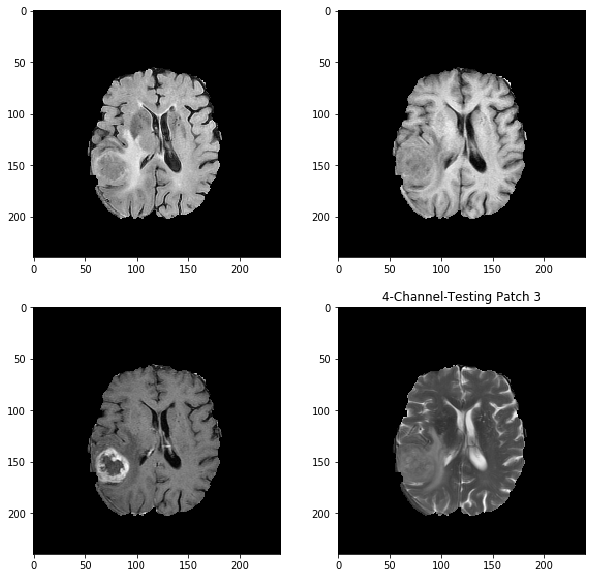

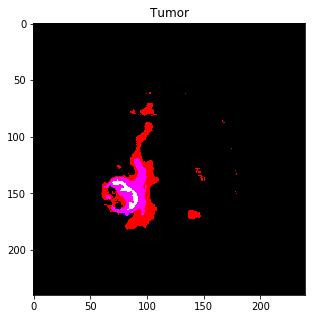

In [15]:
test_segmentation(3)

43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)
43264


C:\Users\Juan\anaconda3\envs\Image_Processing\lib\site-packages\torch\nn\functional.py:2479: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(433,)
(43264, 33, 33)
(43264, 33, 33)
(43264, 33, 33)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(240, 240, 3)


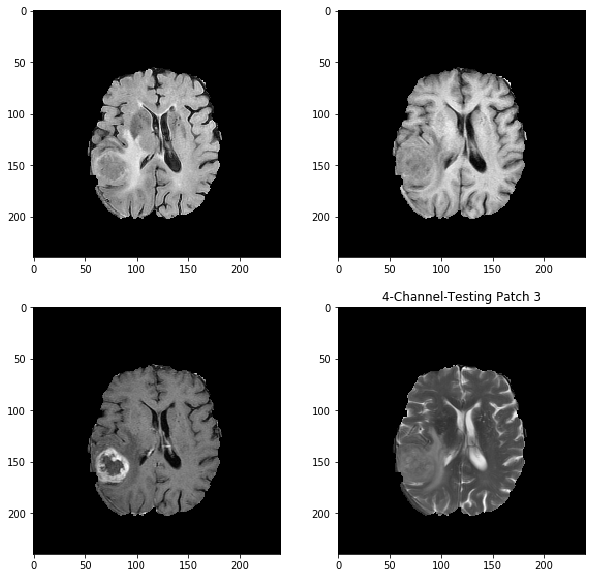

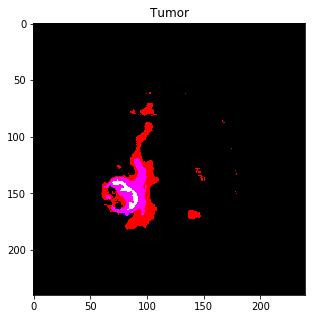

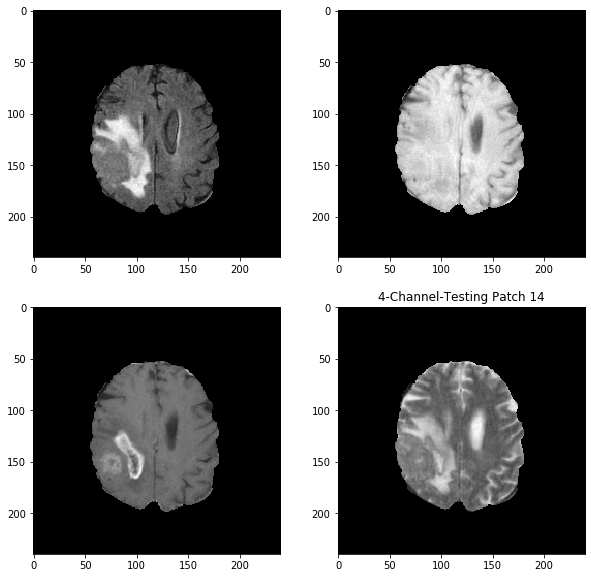

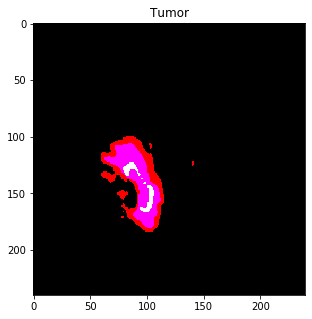

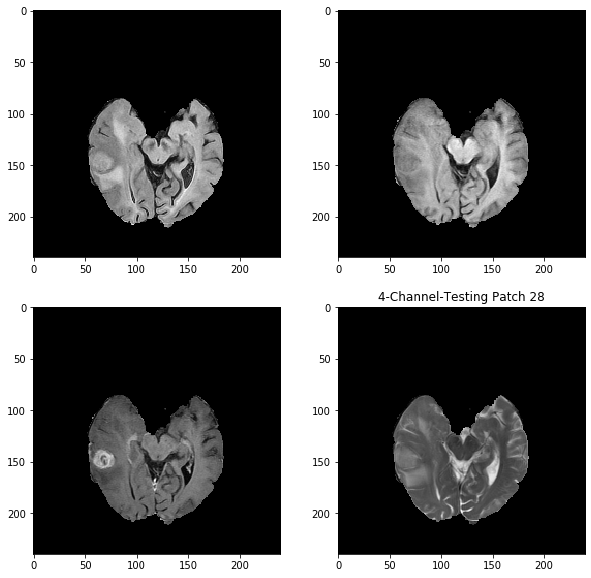

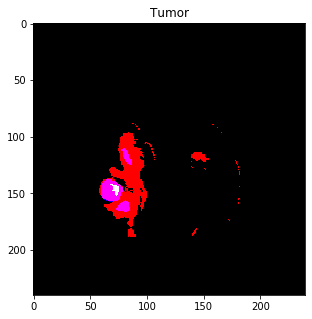

In [16]:
test_cases=[3,14,28]
for i in range(len(test_cases)):
    test_segmentation(test_cases[i])